In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
# from tqdm import tqdm_notebook as tqdm
import cv2
from keras.utils import np_utils

from sklearn.model_selection import train_test_split



import keras
import tensorflow
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
from keras.layers import Input, Conv2D, Lambda,Activation,ZeroPadding2D, Conv2DTranspose, Add, Dense,MaxPool2D,Concatenate,Reshape,Embedding, LeakyReLU,Flatten,MaxPooling2D,Dropout, BatchNormalization,UpSampling2D,GlobalMaxPooling2D, GlobalAveragePooling2D
# from tensorflow.keras.engine.input_layer import Input
from keras.layers import merge
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
import numpy.random as rng
from sklearn.utils import shuffle

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

HEIGHT = 137
WIDTH = 236
SIZE = 84
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=SIZE, pad=16):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size)) /255

In [3]:
train = [
    'train_image_data_0.parquet',
    'train_image_data_1.parquet',
    'train_image_data_2.parquet',
    'train_image_data_3.parquet'
]

test = [
    'test_image_data_0.parquet',
    'test_image_data_1.parquet',
    'test_image_data_2.parquet',
    'test_image_data_3.parquet'
]


## Resizing and cropping the images 

In [ ]:
import imageio


im = 255 - imageio.imread('./gr/0.png')[:,:,0]
print(im.shape)

HEIGHT = im.shape[0]
WIDTH = im.shape[1]

# plt.imshow(im, cmap = 'gray')
plt.imshow(crop_resize(im), cmap = 'gray')

In [ ]:
dico_gr = {}
for i in range(168):
#     print(i)
    im = 255 - imageio.imread('./gr/'+str(i)+'.png')[:,:,0]
    HEIGHT = im.shape[0]
    WIDTH = im.shape[1]
    im = crop_resize(im)
    dico_gr[i] = im
    
dico_cd = {}
dico_cd[0] = np.zeros((84,84,))
for i in range(1,7):
#     print(i)
    im = 255 - imageio.imread('./cd/'+str(i)+'.png')[:,:,0]
    HEIGHT = im.shape[0]
    WIDTH = im.shape[1]
    im = crop_resize(im)
    dico_cd[i] = im

dico_vd = {}
dico_vd[0] = np.zeros((84,84,))
for i in range(1, 11):
#     print(i)
    im = 255 - imageio.imread('./vd/'+str(i)+'.png')[:,:,0]
    HEIGHT = im.shape[0]
    WIDTH = im.shape[1]
    im = crop_resize(im)
    dico_vd[i] = im
    
save((dico_gr, dico_cd, dico_vd), 'dico base images')

In [ ]:
for i in range(4):
#     if i != 0:
    df = pd.read_parquet(train[i])
    
    dataset = list(np.zeros(df.shape[0]))
    ids = df['image_id'].values
    
    for j in tqdm(range(df.shape[0])):
        img = 255 - df.iloc[j].values[1:].astype(np.uint8).reshape((137, 236))
        img = crop_resize(img)
        dataset[j] = img
    
    dataset = np.array(dataset)
    
    save((dataset, ids), 'train_set_'+str(i))

In [ ]:
for i in range(4):
    df = pd.read_parquet(test[i])
    
    dataset = list(np.zeros(df.shape[0]))
    ids = df['image_id'].values
    
    for j in tqdm(range(df.shape[0])):
        img = 255 - df.iloc[j].values[1:].astype(np.uint8).reshape((137, 236))
        img = crop_resize(img)
        dataset[j] = img
    
    dataset = np.array(dataset)
    
    save((dataset, ids), 'test_set_'+str(i))

## Loading the preprocessed images

In [4]:
dataset, ids = load('train_set_0')

for i in range(1,4):
    dataset1, ids1 = load('train_set_'+str(i))
    
    dataset = np.concatenate([dataset, dataset1], axis = 0)
    ids = np.concatenate([ids, ids1], axis = 0)

In [4]:
dataset, ids = load('train_set_0')

In [6]:
dataset  = dataset.reshape((dataset.shape[0],84,84,1))
# dataset = dataset[:200]

labels = pd.read_csv('train.csv')

labels.index = labels['image_id'].values

GR = labels.loc[ids]['grapheme_root'].values
VD = labels.loc[ids]['vowel_diacritic'].values
CD = labels.loc[ids]['consonant_diacritic'].values

gr = np_utils.to_categorical(GR)
vd = np_utils.to_categorical(VD)
cd = np_utils.to_categorical(CD)


# (dico_gr, dico_cd, dico_vd) = load('dico base images')

# def build_image(X, dico_X):
#     Y = list(np.zeros(X.shape[0]))
    
#     for elt in range(len(X)):
#         Y[elt] = dico_X[X[elt]]
    
#     Y = np.array(Y)
#     return Y

# GR1 = build_image(GR, dico_gr).reshape((dataset.shape[0],84,84,1))
# VD1 = build_image(VD, dico_gr).reshape((dataset.shape[0],84,84,1))
# CD1 = build_image(CD, dico_gr).reshape((dataset.shape[0],84,84,1))

y = np.concatenate([gr, vd, cd], axis = 1)

In [33]:
labels[(labels['grapheme_root']==15)&(labels['vowel_diacritic']==9)&(labels['consonant_diacritic']==5)]

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
Train_0,Train_0,15,9,5,ক্ট্রো
Train_137,Train_137,15,9,5,ক্ট্রো
Train_431,Train_431,15,9,5,ক্ট্রো
Train_503,Train_503,15,9,5,ক্ট্রো
Train_1094,Train_1094,15,9,5,ক্ট্রো
...,...,...,...,...,...
Train_194183,Train_194183,15,9,5,ক্ট্রো
Train_194275,Train_194275,15,9,5,ক্ট্রো
Train_194423,Train_194423,15,9,5,ক্ট্রো
Train_196277,Train_196277,15,9,5,ক্ট্রো


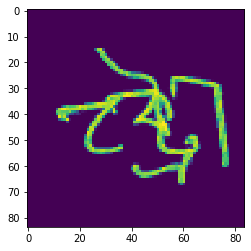

In [32]:
plt.imshow(dataset[7346].reshape(84,84))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2, random_state=42)

In [7]:
del dataset

In [15]:
import keras
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
 
class print_score(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.aucs = []
        self.losses = []
 
    def on_train_end(self, logs={}):
        return
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
#     def on_epoch_end(self, epoch, logs={}):
#         self.losses.append(logs.get('loss'))
        
#         y_pred = self.model.predict(X_test)
#         pred_gr = y_pred[:,:168]
#         pred_vd = y_pred[:,168:179]
#         pred_cd = y_pred[:, 179:]
        
#         y_gr = y_test[:,:168]
#         y_vd = y_test[:,168:179]
#         y_cd = y_test[:, 179:]
        
#         pred_gr = np.argmax(pred_gr, axis = 1)
#         pred_vd = np.argmax(pred_vd, axis = 1)
#         pred_cd = np.argmax(pred_cd, axis = 1)
        
#         y_gr = np.argmax(y_gr, axis = 1)
#         y_vd = np.argmax(y_vd, axis = 1)
#         y_cd = np.argmax(y_cd, axis = 1)
        
#         p_gr = recall_score(y_gr, pred_gr, average='macro')
#         p_vd = recall_score(y_vd, pred_vd, average='macro')
#         p_cd = recall_score(y_cd, pred_cd, average='macro')
        
#         score = 0.5*p_gr + 0.25*p_vd + 0.25*p_cd

#         a_gr = accuracy_score(y_gr, pred_gr)
#         a_vd = accuracy_score(y_vd, pred_vd)
#         a_cd = accuracy_score(y_cd, pred_cd)
    
#         print('recall scores : gr = '+str(p_gr)+' vd = '+str(p_vd)+' cd = '+str(p_cd))
#         print('global score is : '+str(score))
#         print('accuracy scores : gr = '+str(a_gr)+' vd = '+str(a_vd)+' cd = '+str(a_cd))        
        
        
        
#         self.aucs.append(score)
#         print(score)
#         return

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        
        y_pred = self.model.predict(X_test)
        
        pred_gr = np.argmax(y_pred, axis = 1)

        y_gr = np.argmax(y_test, axis = 1)

        
        p_gr = recall_score(y_gr, pred_gr, average='macro')
    

        a_gr = accuracy_score(y_gr, pred_gr)
   
        print('recall scores : gr = '+str(p_gr))
        print('accuracy scores : gr = '+str(a_gr))        
        
        
        
#         self.aucs.append(score)
#         print(score)
        return

    def on_batch_begin(self, batch, logs={}):
        return
 
    def on_batch_end(self, batch, logs={}):
        return

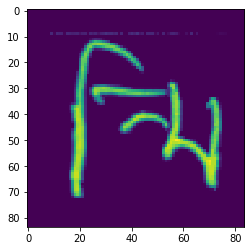

In [9]:
plt.imshow(X_train[0].reshape(84,84))

In [10]:
y_train.shape

(160672, 168)

In [11]:
import resnet
build = resnet.ResnetBuilder()
model = build.build_resnet_18((1,84,84),168)

In [ ]:
from keras.applications import densenet
model_transfert = densenet.DenseNet121(include_top=False,input_shape=(84,84,1), weights = None  )

inputs = model_transfert.input
outputs = model_transfert.output
outputs = GlobalAveragePooling2D(name='avg_pool')(outputs)
outputs = Dense(186, activation='softmax', name='fc64')(outputs)
model = Model(inputs=inputs,   outputs=outputs)

In [ ]:
from resnext import ResNext

model = ResNext((84, 84, 1), depth=20, cardinality=4, width=16, classes = 186)

In [ ]:
model.summary()

In [ ]:
help(c)

In [ ]:
model = load('resnet18 - altered - to_train', 'models')

In [16]:
# aug = ImageDataGenerator(rotation_range=10, zoom_range=0.15,
#                          width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
#                          horizontal_flip=False, fill_mode="nearest")

# from keras_tqdm import TQDMNotebookCallback

aug = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.15, # Randomly zoom image 
            width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images


optimizer=SGD(lr=0.1)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,#keras.optimizers.Adadelta(),
              metrics=['accuracy'])
#              )

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.001, verbose = 1),
    EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto', restore_best_weights = True),
    print_score()
]


batch_size = 32
epochs = 30

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,verbose=1, callbacks = callbacks)


# history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, y_test),verbose=0, callbacks=[TQDMNotebookCallback()])

Epoch 1/30
5021/5021 [==============================] - 177s 35ms/step - loss: 1.2287 - acc: 0.8411 - val_loss: 1.2044 - val_acc: 0.8345
recall scores : gr = 0.7995962871400754
accuracy scores : gr = 0.834520015933081
Epoch 2/30
5021/5021 [==============================] - 172s 34ms/step - loss: 1.0546 - acc: 0.8659 - val_loss: 0.9939 - val_acc: 0.8761
recall scores : gr = 0.8423340376231391
accuracy scores : gr = 0.8761202947619996
Epoch 3/30
5021/5021 [==============================] - 172s 34ms/step - loss: 0.9311 - acc: 0.8803 - val_loss: 0.8715 - val_acc: 0.8904
recall scores : gr = 0.8523338771723183
accuracy scores : gr = 0.8903604859589723
Epoch 4/30
5021/5021 [==============================] - 172s 34ms/step - loss: 0.8358 - acc: 0.8917 - val_loss: 0.8106 - val_acc: 0.8915
recall scores : gr = 0.8800663176273489
accuracy scores : gr = 0.8914807807209719
Epoch 5/30
5021/5021 [==============================] - 172s 34ms/step - loss: 0.7635 - acc: 0.8975 - val_loss: 0.8418 - val_

In [ ]:
save(model, 'resnet18 - altered', 'models')

In [ ]:
optimizer=SGD(lr=0.01)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,#keras.optimizers.Adadelta(),
              metrics=['accuracy'])

batch_size = 32
epochs = 10


history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,verbose=1, callbacks = callbacks)

In [ ]:
optimizer=SGD(lr=0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,#keras.optimizers.Adadelta(),
              metrics=['accuracy'])



batch_size = 32
epochs = 5

history = model.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test), steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,verbose=1, callbacks = callbacks)

In [ ]:
from sklearn.metrics import recall_score

pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1)

Y_true = np.argmax(y_test, axis = 1)

print(recall_score(Y_true, pred, average='macro'))

In [ ]:
def score(X_test, y_test, model):
    
    from sklearn.metrics import recall_score
    from sklearn.metrics import accuracy_score
    y_pred = model.predict(X_test)
    pred_gr = y_pred[:,:168]
    pred_vd = y_pred[:,168:179]
    pred_cd = y_pred[:, 179:]
        
    y_gr = y_test[:,:168]
    y_vd = y_test[:,168:179]
    y_cd = y_test[:, 179:]
        
    pred_gr = np.argmax(pred_gr, axis = 1)
    pred_vd = np.argmax(pred_vd, axis = 1)
    pred_cd = np.argmax(pred_cd, axis = 1)
        
    y_gr = np.argmax(y_gr, axis = 1)
    y_vd = np.argmax(y_vd, axis = 1)
    y_cd = np.argmax(y_cd, axis = 1)
        
    p_gr = recall_score(y_gr, pred_gr, average='macro')
    p_vd = recall_score(y_vd, pred_vd, average='macro')
    p_cd = recall_score(y_cd, pred_cd, average='macro')
    
    a_gr = accuracy_score(y_gr, pred_gr)
    a_vd = accuracy_score(y_vd, pred_vd)
    a_cd = accuracy_score(y_cd, pred_cd)
        
    score = 0.5*p_gr + 0.25*p_vd + 0.25*p_cd
    
    print('recall scores : gr = '+str(p_gr)+' vd = '+str(p_vd)+' cd = '+str(p_cd))
    print('global score is : '+str(score))
    
    print('accuracy scores : gr = '+str(a_gr)+' vd = '+str(a_vd)+' cd = '+str(a_cd))

In [ ]:
def ensemble_score(X_test, y_test, models, weights):
    
    from sklearn.metrics import recall_score
    from sklearn.metrics import accuracy_score
    
    preds = [[] for i in range(len(models))]
    for j in range(len(models)):
        print(' model '+str(j))
        model = load(models[j], 'models')
            
        pred = model.predict(X_test)
        print(pred.shape)
#       print(pred)
        preds[j] = pred
        
    preds = np.array(preds)
    
    print(preds.shape)
    
    pred = weights[0] * preds[0]
    for i in range(1,len(models)):
        pred += preds[i] * weights[i]
    
    y_pred = pred
#     y_pred = model.predict(X_test)
    pred_gr = y_pred[:,:168]
    pred_vd = y_pred[:,168:179]
    pred_cd = y_pred[:, 179:]
        
    y_gr = y_test[:,:168]
    y_vd = y_test[:,168:179]
    y_cd = y_test[:, 179:]
        
    pred_gr = np.argmax(pred_gr, axis = 1)
    pred_vd = np.argmax(pred_vd, axis = 1)
    pred_cd = np.argmax(pred_cd, axis = 1)
        
    y_gr = np.argmax(y_gr, axis = 1)
    y_vd = np.argmax(y_vd, axis = 1)
    y_cd = np.argmax(y_cd, axis = 1)
        
    p_gr = recall_score(y_gr, pred_gr, average='macro')
    p_vd = recall_score(y_vd, pred_vd, average='macro')
    p_cd = recall_score(y_cd, pred_cd, average='macro')
    
    a_gr = accuracy_score(y_gr, pred_gr)
    a_vd = accuracy_score(y_vd, pred_vd)
    a_cd = accuracy_score(y_cd, pred_cd)
        
    score = 0.5*p_gr + 0.25*p_vd + 0.25*p_cd
    
    print('recall scores : gr = '+str(p_gr)+' vd = '+str(p_vd)+' cd = '+str(p_cd))
    print('global score is : '+str(score))
    
    print('accuracy scores : gr = '+str(a_gr)+' vd = '+str(a_vd)+' cd = '+str(a_cd))

In [ ]:
models = [
    'resnet18',
    'densenet121',
    'resnet18 - altered'
]

weights = [
    0.3,
    0.4,
    0.3
]

In [ ]:
ensemble_score(X_test, y_test, models, weights)

In [ ]:
model = load('resnet18', 'models')

In [ ]:
score(X_test, y_test, model)